<a href="https://colab.research.google.com/github/Charan1010/Race-change-using-Cycle-Generative-Adversarial-Networks/blob/master/cycle_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
 !pip3 install torchgan

In [0]:
import os, sys, glob, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchgan
from torchgan.models import Generator, Discriminator

from torchgan.trainer import Trainer
from torchgan.losses import GeneratorLoss, DiscriminatorLoss,\
                            least_squares_generator_loss, least_squares_discriminator_loss
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd  "/content/drive/My Drive/colab"

/content/drive/My Drive/colab


In [0]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '{}A'.format(mode)) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '{}B'.format(mode)) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))
        item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))
        
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [0]:
dataset = ImageDataset("./static/face2asian",
                       transform=transforms.Compose([transforms.Resize(75),
                                                     transforms.CenterCrop(64),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                                                          std=(0.5, 0.5, 0.5))]))

In [0]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=8)

In [0]:
a = next(iter(dataloader))

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

In [0]:
a['A'].shape

torch.Size([64, 3, 64, 64])

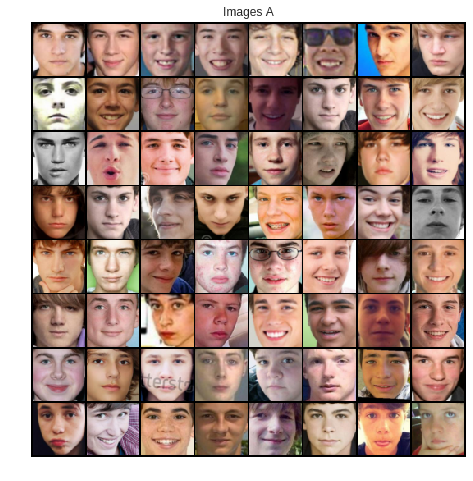

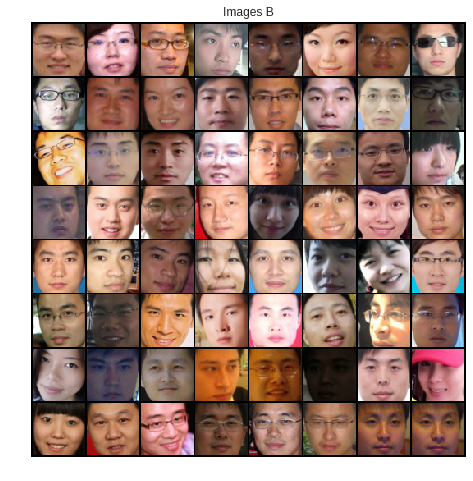

In [0]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images A")
plt.imshow(np.transpose(vutils.make_grid(a['A'].to(torch.device("cuda:0"))[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images B")
plt.imshow(np.transpose(vutils.make_grid(a['B'].to(torch.device("cuda:0"))[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(nn.ReflectionPad2d(1),
                                        nn.Conv2d(in_features, in_features, 3),
                                        nn.InstanceNorm2d(in_features),
                                        nn.ReLU(inplace=True),
                                        nn.ReflectionPad2d(1),
                                        nn.Conv2d(in_features, in_features, 3),
                                        nn.InstanceNorm2d(in_features))

    def forward(self, x):
        return x + self.conv_block(x)


In [0]:
class CycleGANGenerator(Generator):
    def __init__(self, image_batch, in_channels=3, out_channels=3, res_blocks=5):
        super(CycleGANGenerator, self).__init__(in_channels)

        self.image_batch = image_batch

        # Initial convolution block
        model = [nn.ReflectionPad2d(3), nn.Conv2d(in_channels, 64, 7),
                 nn.InstanceNorm2d(64), nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 4, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features), nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(res_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 4, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features), nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3), nn.Conv2d(64, out_channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

        self._weight_initializer()

    def forward(self, x):
        return self.model(x)

    def sampler(self, sample_size, device):
        return [self.image_batch.to(device)]

In [0]:
class CycleGANDiscriminator(Discriminator):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1))

        self._weight_initializer()

    def forward(self, x):
        return self.model(x)

In [0]:
class CycleGANGeneratorLoss(GeneratorLoss):
    def train_ops(self, gen_a2b, gen_b2a, dis_a, dis_b, optimizer_gen_a2b, optimizer_gen_b2a,
                  image_a, image_b):
        optimizer_gen_a2b.zero_grad()
        optimizer_gen_b2a.zero_grad()
        fake_a = gen_b2a(image_b)
        fake_b = gen_a2b(image_a)
        loss_identity = 0.5 * (F.l1_loss(fake_a, image_a) + F.l1_loss(fake_b, image_b))
        loss_gan = 0.5 * (least_squares_generator_loss(dis_a(fake_a)) +\
                   least_squares_generator_loss(dis_b(fake_b)))
        loss_cycle_consistency = 0.5*(F.l1_loss(gen_a2b(fake_a), image_b) +\
                                 F.l1_loss(gen_b2a(fake_b), image_a))
        loss = loss_identity + loss_gan + loss_cycle_consistency
        loss.backward()
        optimizer_gen_a2b.step()
        optimizer_gen_b2a.step()
        return loss.item()

In [0]:
class CycleGANDiscriminatorLoss(DiscriminatorLoss):
    def train_ops(self, gen_a2b, gen_b2a, dis_a, dis_b, optimizer_dis_a, optimizer_dis_b,
                  image_a, image_b):
        optimizer_dis_a.zero_grad()
        optimizer_dis_b.zero_grad()
        fake_a = gen_b2a(image_b).detach()
        fake_b = gen_a2b(image_a).detach()
        loss = 0.5 * (least_squares_discriminator_loss(dis_a(image_a), dis_a(fake_a)) +
                      least_squares_discriminator_loss(dis_b(image_b), dis_b(fake_b)))
        loss.backward()
        optimizer_dis_a.step()
        optimizer_dis_b.step()
        return loss.item()

In [0]:
class CycleGANTrainer(Trainer):
    def train_iter_custom(self):
        self.image_a = self.real_inputs['A'].to(self.device)
        self.image_b = self.real_inputs['B'].to(self.device)


In [0]:
device = torch.device("cuda:0")


In [0]:
image_batch = next(iter(dataloader))

In [0]:
network_config = {
    "gen_a2b": {"name": CycleGANGenerator, "args": {"image_batch": image_batch['A']},
                "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "gen_b2a": {"name": CycleGANGenerator, "args": {"image_batch": image_batch['B']},
                "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "dis_a": {"name": CycleGANDiscriminator,
              "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "dis_b": {"name": CycleGANDiscriminator,
              "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}}
}


In [0]:
losses = [CycleGANGeneratorLoss(), CycleGANDiscriminatorLoss()]

In [0]:
trainer = CycleGANTrainer(network_config, losses, device=device, epochs=100, image_a=None, image_b=None)


In [0]:
trainer.load_model("./model/gan_white.model")

Loading Model From './model/gan_white.model'


In [0]:
trainer(dataloader)


Saving Model at './model/gan0.model'


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CycleGANGeneratorLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CycleGANDiscriminatorLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1 Summary
gen_a2b Mean Gradients : 12.857771572163449
gen_b2a Mean Gradients : 14.320349963895119
dis_a Mean Gradients : 4.0848692532892645
dis_b Mean Gradients : 4.460563745622907
Mean Running Discriminator Loss : 0.5001435005475604
Mean Running Generator Loss : 1.1404949795632136
Generating and Saving Images to ./images/epoch1_gen_a2b.png
Generating and Saving Images to ./images/epoch1_gen_b2a.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
gen_a2b Mean Gradients : 7.572424004460092
gen_b2a Mean Gradients : 8.452725551850724
dis_a Mean Gradients : 3.117042886980165
dis_b Mean Gradients : 2.9808848950548716
Mean Running Discriminator Loss : 0.426813547336866
Mean Running Generator Loss : 1.0215901983162714
Generating and Saving Images to ./images/epoch2_gen_a2b.png
Generating and Saving Images to ./images/epoch2_gen_b2a.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
gen_a2b Mean Gradients : 5.632686867760808
gen_b2a Mean Gradients : 6.305321498062229
dis_a M

Process Process-392:
Process Process-386:
Process Process-385:
Process Process-390:
Process Process-389:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-388:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-387:
  File "/usr/lib/python3.6/multiprocess

KeyboardInterrupt: ignored

In [0]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
import signal 
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True


In [0]:
vc = cv2.VideoCapture(0)

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    plt.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.05)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break

In [0]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

VIDEO_HTML = """
<video autoplay
 width=800 height=600></video>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo1.jpg', quality=0.1):
  display(HTML(VIDEO_HTML % quality))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

In [86]:
take_photo()

4637

In [0]:
trainer.gen_a2b
torch.save(trainer.gen_a2b.state_dict(), './static/model_states.pwf')


In [0]:
model =trainer.gen_a2b
model.load_state_dict(torch.load('./static/model_states.pwf'))
model.eval()

CycleGANGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(2

In [0]:
%matplotlib inline
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [0]:
model(image_batch['A'].cuda()).shape

torch.Size([64, 3, 64, 64])

In [0]:
image_batch['A'].to(torch.device("cuda:0"))[:64].shape

torch.Size([64, 3, 64, 64])

In [0]:
dataset1 = ImageDataset("./static/bear2panda",
                       transform=transforms.Compose([transforms.Resize(256),
                                                     transforms.CenterCrop(256),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                                                          std=(0.5, 0.5, 0.5))]))

In [0]:
dataloader1 = DataLoader(dataset1, batch_size=16, shuffle=False, num_workers=8)

In [0]:
test_set=next(iter(dataloader1))

In [0]:
test_set['A'].size()

torch.Size([16, 3, 256, 256])

In [0]:
iteration1=iter(dataloader)

In [0]:
image_batch = next(iteration1)

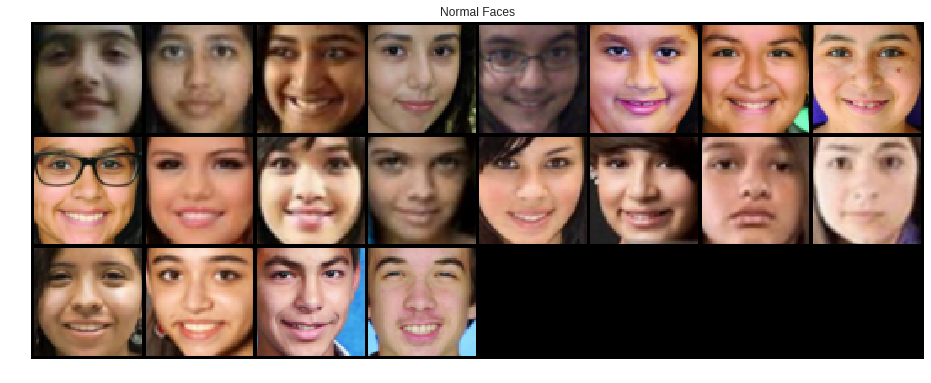

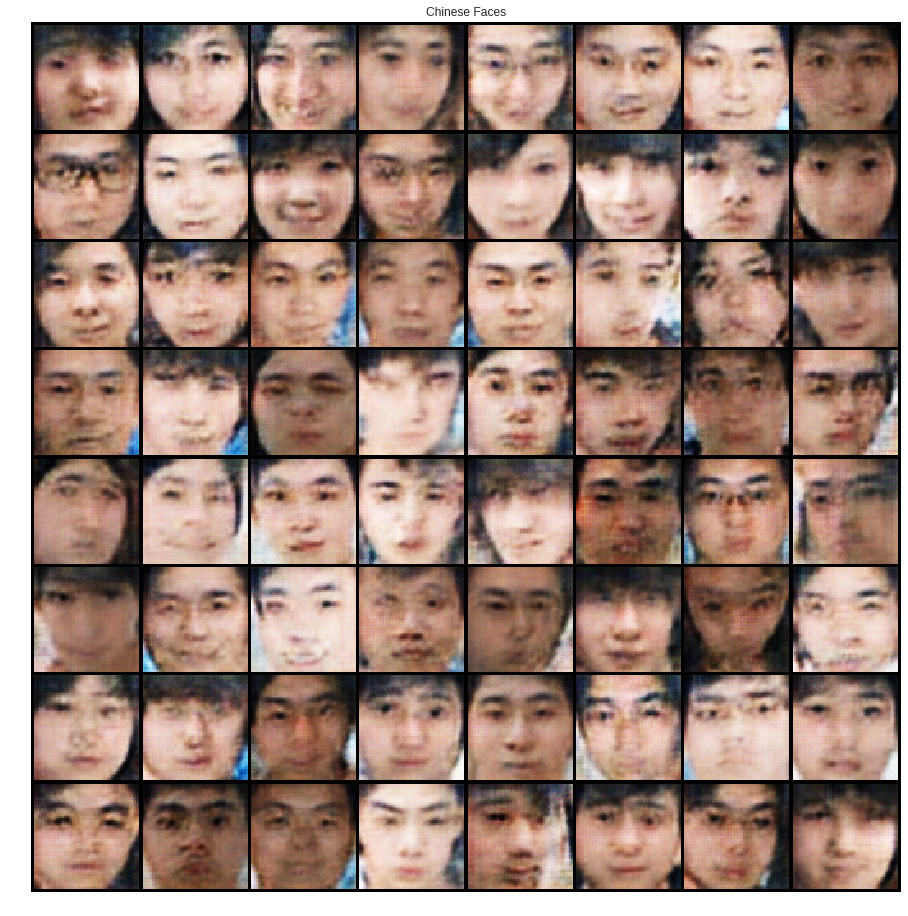

In [132]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Normal Faces")
plt.imshow(np.transpose(vutils.make_grid(image_batch['A'].to(torch.device("cuda:0"))[:20], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Chinese Faces")

plt.imshow(np.transpose(vutils.make_grid(trainer.gen_a2b(image_batch['A'].cuda()).detach(), padding=2,normalize=True).cpu().numpy(),(1,2,0)))
plt.show()


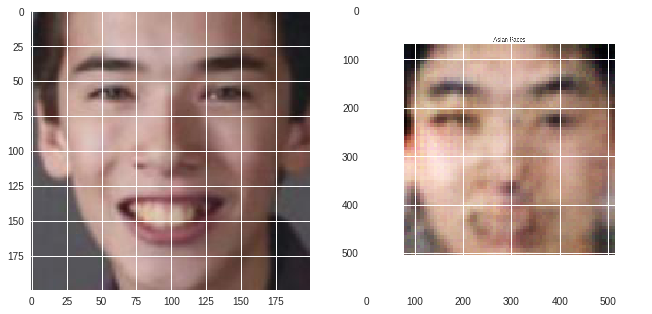

In [141]:
image_name="Teethboy"
def image_loader(loader, image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image)
    
    image = image.unsqueeze(0)
    return image


data_transforms=transforms.Compose([transforms.Resize(75),
                                                     transforms.CenterCrop(64),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                                                          std=(0.5, 0.5, 0.5))])
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Asian Faces")

plt.imshow(np.transpose(vutils.make_grid(trainer.gen_a2b(image_loader(data_transforms,'./static/face2asian/trainA/'+image_name+'.jpg' ).cuda()).detach(), padding=2,normalize=True).cpu().numpy(),(1,2,0)))
from google.colab import files
plt.savefig(image_name+"_asian.png")
#files.download("abc.png") 
#plt.show()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread('./static/face2asian/trainA/'+image_name+'.jpg')
img_B = mpimg.imread(image_name+"_asian.png")

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);
#fig.grid(False)

# Hide axes ticks
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])

#model_ft = models.resnet152(pretrained=True)
#model_ft.eval()

#print( np.argmax(model_ft(image_loader(data_transforms, $FILENAME)).detach().numpy()))


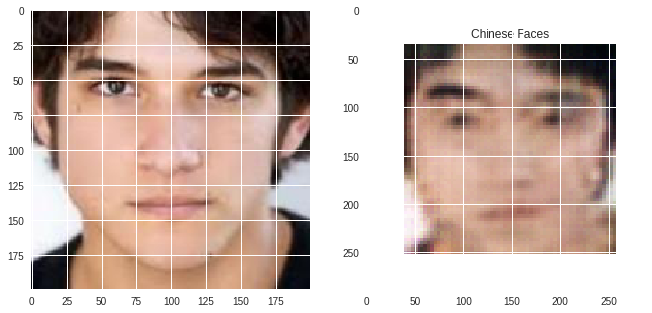